# Overhead (Multi parameter) 


This is the Notebook used to analyze whether any additional overhead is added by parameter control.

It is divided into the main sections:

- Prior Predictive Check
- Model specification
- Data analysis

# Prior Predictive Check

Sampling: [a_bar, a_offset, b_offset, sigma_a, sigma_b, theta]


<Figure size 400x300 with 0 Axes>

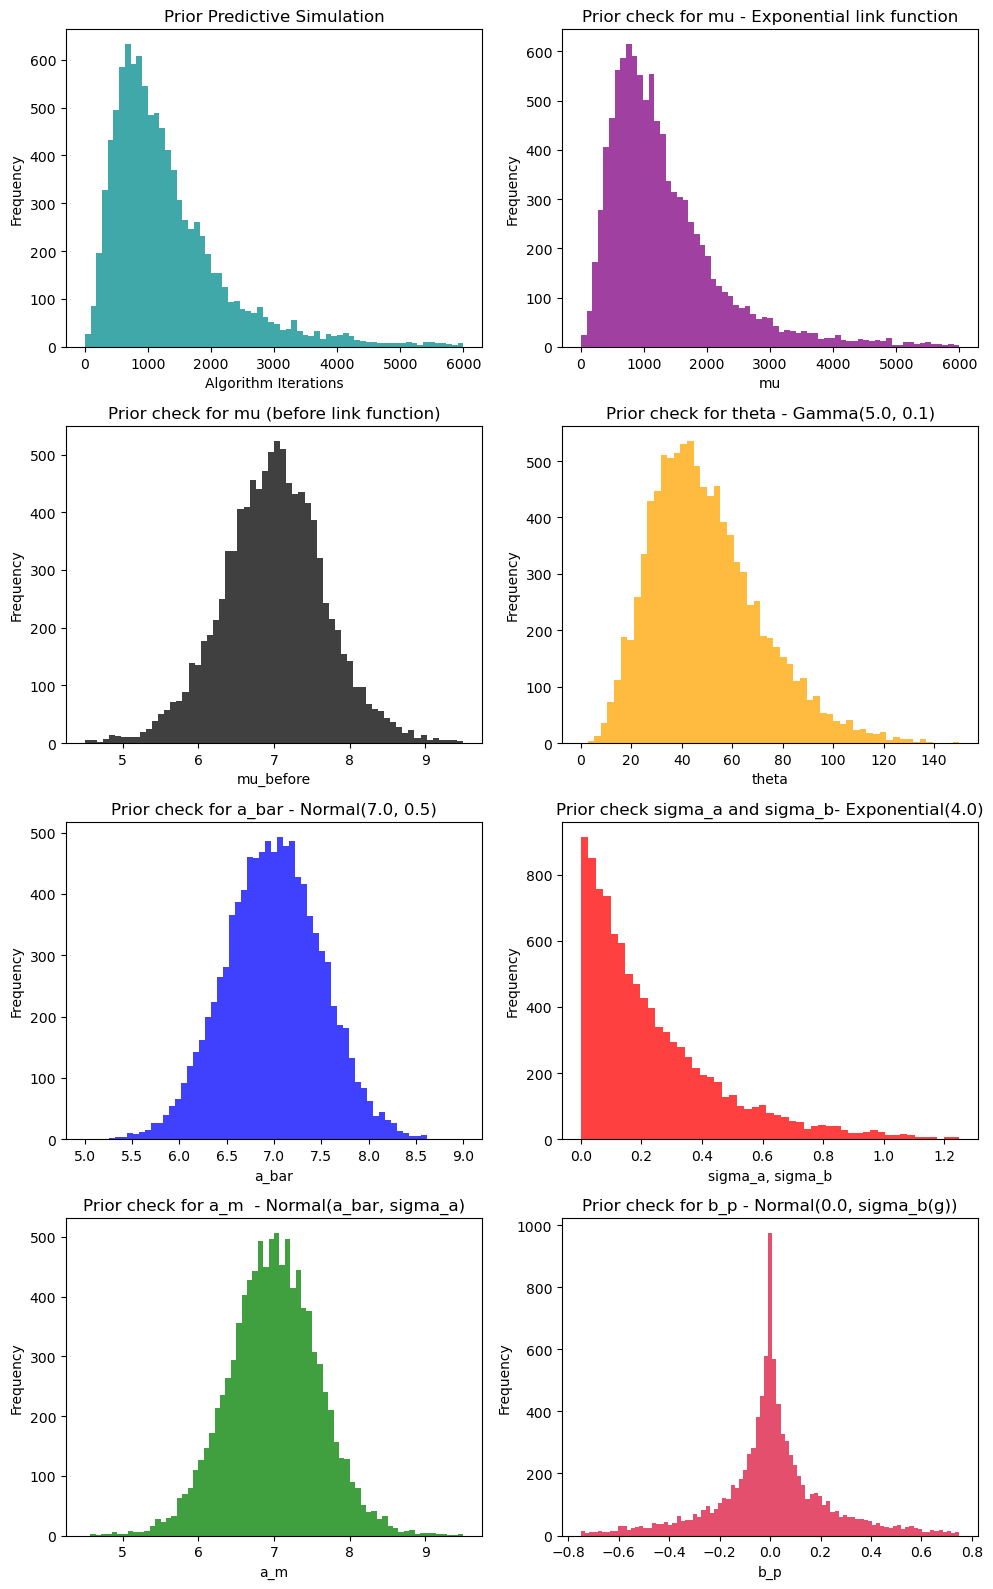

In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipywidgets import interact, FloatSlider
from utils.prior_check_helper import HistogramPlot, plot_histograms

def perform_prior_check(s_a, s_b, a_bar_mu, a_bar_sigma):
    with pm.Model():
        # Global Intercept for modules
        a_bar = pm.Normal('a_bar', mu=a_bar_mu, sigma=a_bar_sigma)
        
        # Standard Deviations for Module, Parameter effects
        sigma_a = pm.Exponential('sigma_a', s_a)
        sigma_b = pm.Exponential('sigma_b', s_b)
        
        # Module and Parameter effects with non-centered parameterizations (helps with divergences) 
        a_offset = pm.Normal('a_offset', mu=0, sigma=1)
        a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

        b_offset = pm.Normal('b_offset', mu=0, sigma=1)
        b_p = pm.Deterministic('b_p', sigma_b * b_offset)


        # Link function (exp), from ln to exp
        pm.Deterministic('mu_before', a_m + b_p)
        pm.Deterministic('mu', pm.math.exp(a_m + b_p))
        
        # Gamma distriubtion for theta (dispersion/spread) 
        pm.Gamma('theta', alpha=5.0, beta=0.1)
        
        # Sample priors from the model
        idata = pm.sample_prior_predictive(samples=10000)



    # Fetch and flatten priors
    prior_mu= idata.prior['mu'].values.flatten()
    prior_theta = idata.prior['theta'].values.flatten()

    # Use n and p as parameters for the negative binomial to sample observations
    simulated_observations = np.random.negative_binomial(n=prior_theta, p=(prior_theta)/(prior_mu + prior_theta))
    
    # Plot histogram of observations 
    plt.figure(figsize=(4, 3))
    observation_plot = HistogramPlot(simulated_observations,'Prior Predictive Simulation', 'Algorithm Iterations',
                                     'darkcyan', bin_range=(0,6000))


    # Plot priors for the different parameters
    plots = [
        observation_plot,
        HistogramPlot(idata.prior['mu'].values.flatten(), 'Prior check for mu - Exponential link function', 'mu', 'purple', bin_range=(0, 6000)),
        HistogramPlot(idata.prior['mu_before'].values.flatten(), 'Prior check for mu (before link function)', 'mu_before', 'black', bin_range=(4.5, 9.5)),
        HistogramPlot(idata.prior['theta'].values.flatten(), 'Prior check for theta - Gamma(5.0, 0.1)', 'theta', 'orange', bin_range=(0,150)),
        HistogramPlot(idata.prior['a_bar'].values.flatten(), 'Prior check for a_bar - Normal(7.0, 0.5)', 'a_bar', 'blue', bin_range=(5,9)),
        HistogramPlot(idata.prior['sigma_a'].values.flatten(), 'Prior check sigma_a and sigma_b- Exponential(4.0)', 'sigma_a, sigma_b', 'red', bin_range=(0, 1.25)),
        HistogramPlot(idata.prior['a_m'].values.flatten(), 'Prior check for a_m  - Normal(a_bar, sigma_a)', 'a_m', 'green', bin_range=(4.5,9.5)),
        #HistogramPlot(idata.prior['sigma_b'].values.flatten(), 'Prior check for sigma_b - Exponential(4.0)', 'sigma_b', 'salmon'),
        HistogramPlot(idata.prior['b_p'].values.flatten(), 'Prior check for b_p - Normal(0.0, sigma_b(g))', 'b_p', 'crimson', bin_range=(-0.75, 0.75)),
        #HistogramPlot(idata.prior['sigma_g'].values.flatten(), 'Prior check for sigma_g - Exponential(4.0)', 'sigma_g', 'brown'),
        #HistogramPlot(idata.prior['g_mp'].values.flatten(), 'Prior check for g_mp - Normal(0.0, sigma_g)', 'g_mp', 'yellow', bin_range=(-1.5, 1.5))
    ]

    plot_histograms(plots, 4, 2, figsize=(10,16), save_img=True, prefix_name="overhead_multi", output_folder="prior_checks/overhead_multi")

perform_prior_check(4,4,7,0.5)


### UNCOMMENT FOR INTERACTIVE PRIOR CHECK ###

#s_a = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_alpha (sigma_a):')
#s_b = FloatSlider(value=4, min=0.5, max=6, step=0.1, description='Sigma_beta (sigma_b):')
#a_bar_mu = FloatSlider(value=7, min=0, max=10, step=0.1, description='alpha bar mu (a_bar_mu):')
#a_bar_sigma = FloatSlider(value=0.5, min=0, max=3, step=0.1, description='alpha bar sigma (a_bar_sigma):')

#interact(calc_prior_dist, s_a=s_a, s_b=s_b, a_bar_mu=a_bar_mu, a_bar_sigma=a_bar_sigma)


# Model specification

### Data Preperation


In [3]:
import pymc as pm
import pandas as pd
from utils.design_matrix_creator import get_design_matricies

# Load data
data = pd.read_csv("../multi_parameter/combined_data/statistics.csv")

# Create design matricies that contain dummy variables for each module, parameter and interaction.
observation_matrix, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(data, 'AlgorithmIterations')

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


### Execute the Model

In [ ]:
with pm.Model():
    # Global Intercept for Modules
    a_bar = pm.Normal('a_bar', mu=7, sigma=0.5)
    
    # Standard deviations for Module and Parameter effects
    sigma_a = pm.Exponential('sigma_a', 4.0)
    sigma_b = pm.Exponential('sigma_b', 4.0)
    
    # Module and Parameter effects with non-centered parameterizations (helps with divergences)
    a_offset = pm.Normal('a_offset', mu=0, sigma=1, shape=24)
    a_m = pm.Deterministic('a_m', a_bar + sigma_a * a_offset)

    b_offset = pm.Normal('b_offset', mu=0, sigma=1, shape=66)
    b_p = pm.Deterministic('b_p', sigma_b * b_offset)

    
    # Activate the correct module, parameter and interaction for each run
    log_a = pm.math.dot(module_matrix, a_m)
    log_b = pm.math.dot(parameter_matrix, b_p)

    # Link function (exp), from ln to exp
    mu = pm.Deterministic('mu', pm.math.exp(log_a + log_b))
    
    # Negative Binomial likelihood with parameter n and p
    theta = pm.Gamma('theta', alpha=5.0, beta=0.1) # Dispersion/spread parameter
    Y_obs = pm.NegativeBinomial('Y_obs', n=theta, p=(theta)/(mu + theta), observed=observation_matrix['AlgorithmIterations'])
    
    # Sample from the model
    trace = pm.sample(5000, chains=4, return_inferencedata=True, progressbar=True, target_accept=0.95)
    log_lik = pm.compute_log_likelihood(trace)
    
print("Sampling complete!")

### Save the results

In [ ]:
import arviz as az

az.to_netcdf(trace, "overhead_model_multi_parameter.nc")

# Data analysis 

### Generate summary object (without transformations)

In [1]:
import arviz as az
import pandas as pd
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp
pd.set_option('display.max_rows', 500)


trace = az.from_netcdf("../multi_parameter/overhead_model_multi_parameter.nc")
variable_list = ['a_m', 'b_p', 'a_bar', 'sigma_a', 'sigma_b', 'theta' ]
transformations = {}

idata = create_inference_data_from_trace(trace, variable_list, transformations)
summary = az.summary(idata, variable_list, hdi_prob=0.89)


### Replace numeric identifiers with descriptive identifiers

In [2]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../multi_parameter/combined_data/statistics.csv"), 'AlgorithmIterations')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary, 'a_m', replacement=module_names)
update_table(summary, 'b_p', replacement=parameter_names)
update_table(summary, 'g_mp', replacement=interaction_names)

summary.sort_values(by='mean', ascending=True)

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


mean     sd  hdi_5.5%  hdi_94.5%  \
b_p[Pop|TestInsertionProb]               -0.343  0.017    -0.370     -0.317   
b_p[TestChangeProb|TestInsertionProb]    -0.217  0.017    -0.244     -0.191   
b_p[TestInsertProb|TestInsertionProb]    -0.210  0.017    -0.237     -0.184   
b_p[ChangeParamProb|TestInsertionProb]   -0.206  0.017    -0.233     -0.180   
b_p[ChromLen|TestInsertionProb]          -0.203  0.017    -0.231     -0.178   
b_p[RandPert|TestInsertionProb]          -0.197  0.017    -0.223     -0.170   
b_p[Crossover|TestInsertionProb]         -0.196  0.017    -0.222     -0.169   
b_p[Elite|TestInsertionProb]             -0.195  0.017    -0.221     -0.169   
b_p[TestDeleteProb|TestInsertionProb]    -0.191  0.017    -0.218     -0.165   
b_p[StatemInsertProb|TestInsertionProb]  -0.191  0.016    -0.217     -0.164   
b_p[TestInsertionProb|TourSize]          -0.187  0.017    -0.213     -0.160   
b_p[Pop|TestInsertProb]                  -0.184  0.017    -0.210     -0.157   
b_p[ChromLen|Pop]                        -0.175  0.017    -0.201     -0.148   
b_p[Pop|StatemInsertProb]                -0.175  0.017    -0.202     -0.149   
b_p[Pop|TestDeleteProb]                  -0.172  0.016    -0.198     -0.145   
b_p[Crossover|Pop]                       -0.164  0.017    -0.190     -0.138   
b_p[ChangeParamProb|Pop]                 -0.163  0.017    -0.190     -0.138   
b_p[Elite|Pop]                           -0.162  0.017    -0.189     -0.136   
b_p[Pop|TestChangeProb]                  -0.158  0.017    -0.184     -0.131   
b_p[Pop|TourSize]                        -0.157  0.017    -0.183     -0.130   
b_p[Pop|RandPert]                        -0.142  0.017    -0.169     -0.116   
b_p[StatemInsertProb|TestChangeProb]     -0.038  0.016    -0.063     -0.011   
b_p[Crossover|TestChangeProb]            -0.038  0.016    -0.063     -0.012   
b_p[Crossover|TestDeleteProb]            -0.035  0.016    -0.061     -0.009   
b_p[StatemInsertProb|TestInsertProb]     -0.033  0.016    -0.058     -0.006   
b_p[TestChangeProb|TestInsertProb]       -0.032  0.016    -0.058     -0.006   
b_p[RandPert|TestDeleteProb]             -0.032  0.016    -0.058     -0.005   
b_p[StatemInsertProb|TestDeleteProb]     -0.031  0.016    -0.056     -0.004   
b_p[Elite|StatemInsertProb]              -0.029  0.016    -0.055     -0.002   
b_p[TestDeleteProb|TestInsertProb]       -0.027  0.016    -0.054     -0.002   
b_p[TestChangeProb|TestDeleteProb]       -0.027  0.016    -0.052      0.000   
b_p[Crossover|TestInsertProb]            -0.025  0.016    -0.051      0.001   
b_p[ChromLen|TestDeleteProb]             -0.024  0.016    -0.050      0.002   
b_p[Elite|RandPert]                      -0.022  0.016    -0.047      0.004   
b_p[ChromLen|StatemInsertProb]           -0.022  0.016    -0.049      0.004   
b_p[ChangeParamProb|TestChangeProb]      -0.022  0.016    -0.048      0.004   
b_p[RandPert|TestChangeProb]             -0.020  0.016    -0.045      0.006   
b_p[Elite|TestInsertProb]                -0.019  0.016    -0.044      0.008   
b_p[ChromLen|Crossover]                  -0.018  0.016    -0.043      0.009   
b_p[Crossover|Elite]                     -0.017  0.016    -0.044      0.008   
b_p[Crossover|RandPert]                  -0.017  0.016    -0.042      0.010   
b_p[RandPert|StatemInsertProb]           -0.016  0.016    -0.043      0.010   
b_p[TestInsertProb|TourSize]             -0.013  0.016    -0.039      0.013   
b_p[StatemInsertProb|TourSize]           -0.010  0.016    -0.036      0.017   
b_p[ChromLen|TestChangeProb]             -0.010  0.016    -0.037      0.016   
b_p[ChangeParamProb|TestDeleteProb]      -0.010  0.016    -0.035      0.016   
b_p[TestDeleteProb|TourSize]             -0.009  0.017    -0.035      0.018   
b_p[ChangeParamProb|Crossover]           -0.009  0.016    -0.035      0.017   
b_p[RandPert|TestInsertProb]             -0.008  0.017    -0.035      0.018   
b_p[Crossover|StatemInsertProb]          -0.008  0.016    -0.035      0.018   
b_p[RandPert|T

### Plot the prior distributions and their assosicated trace plots

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

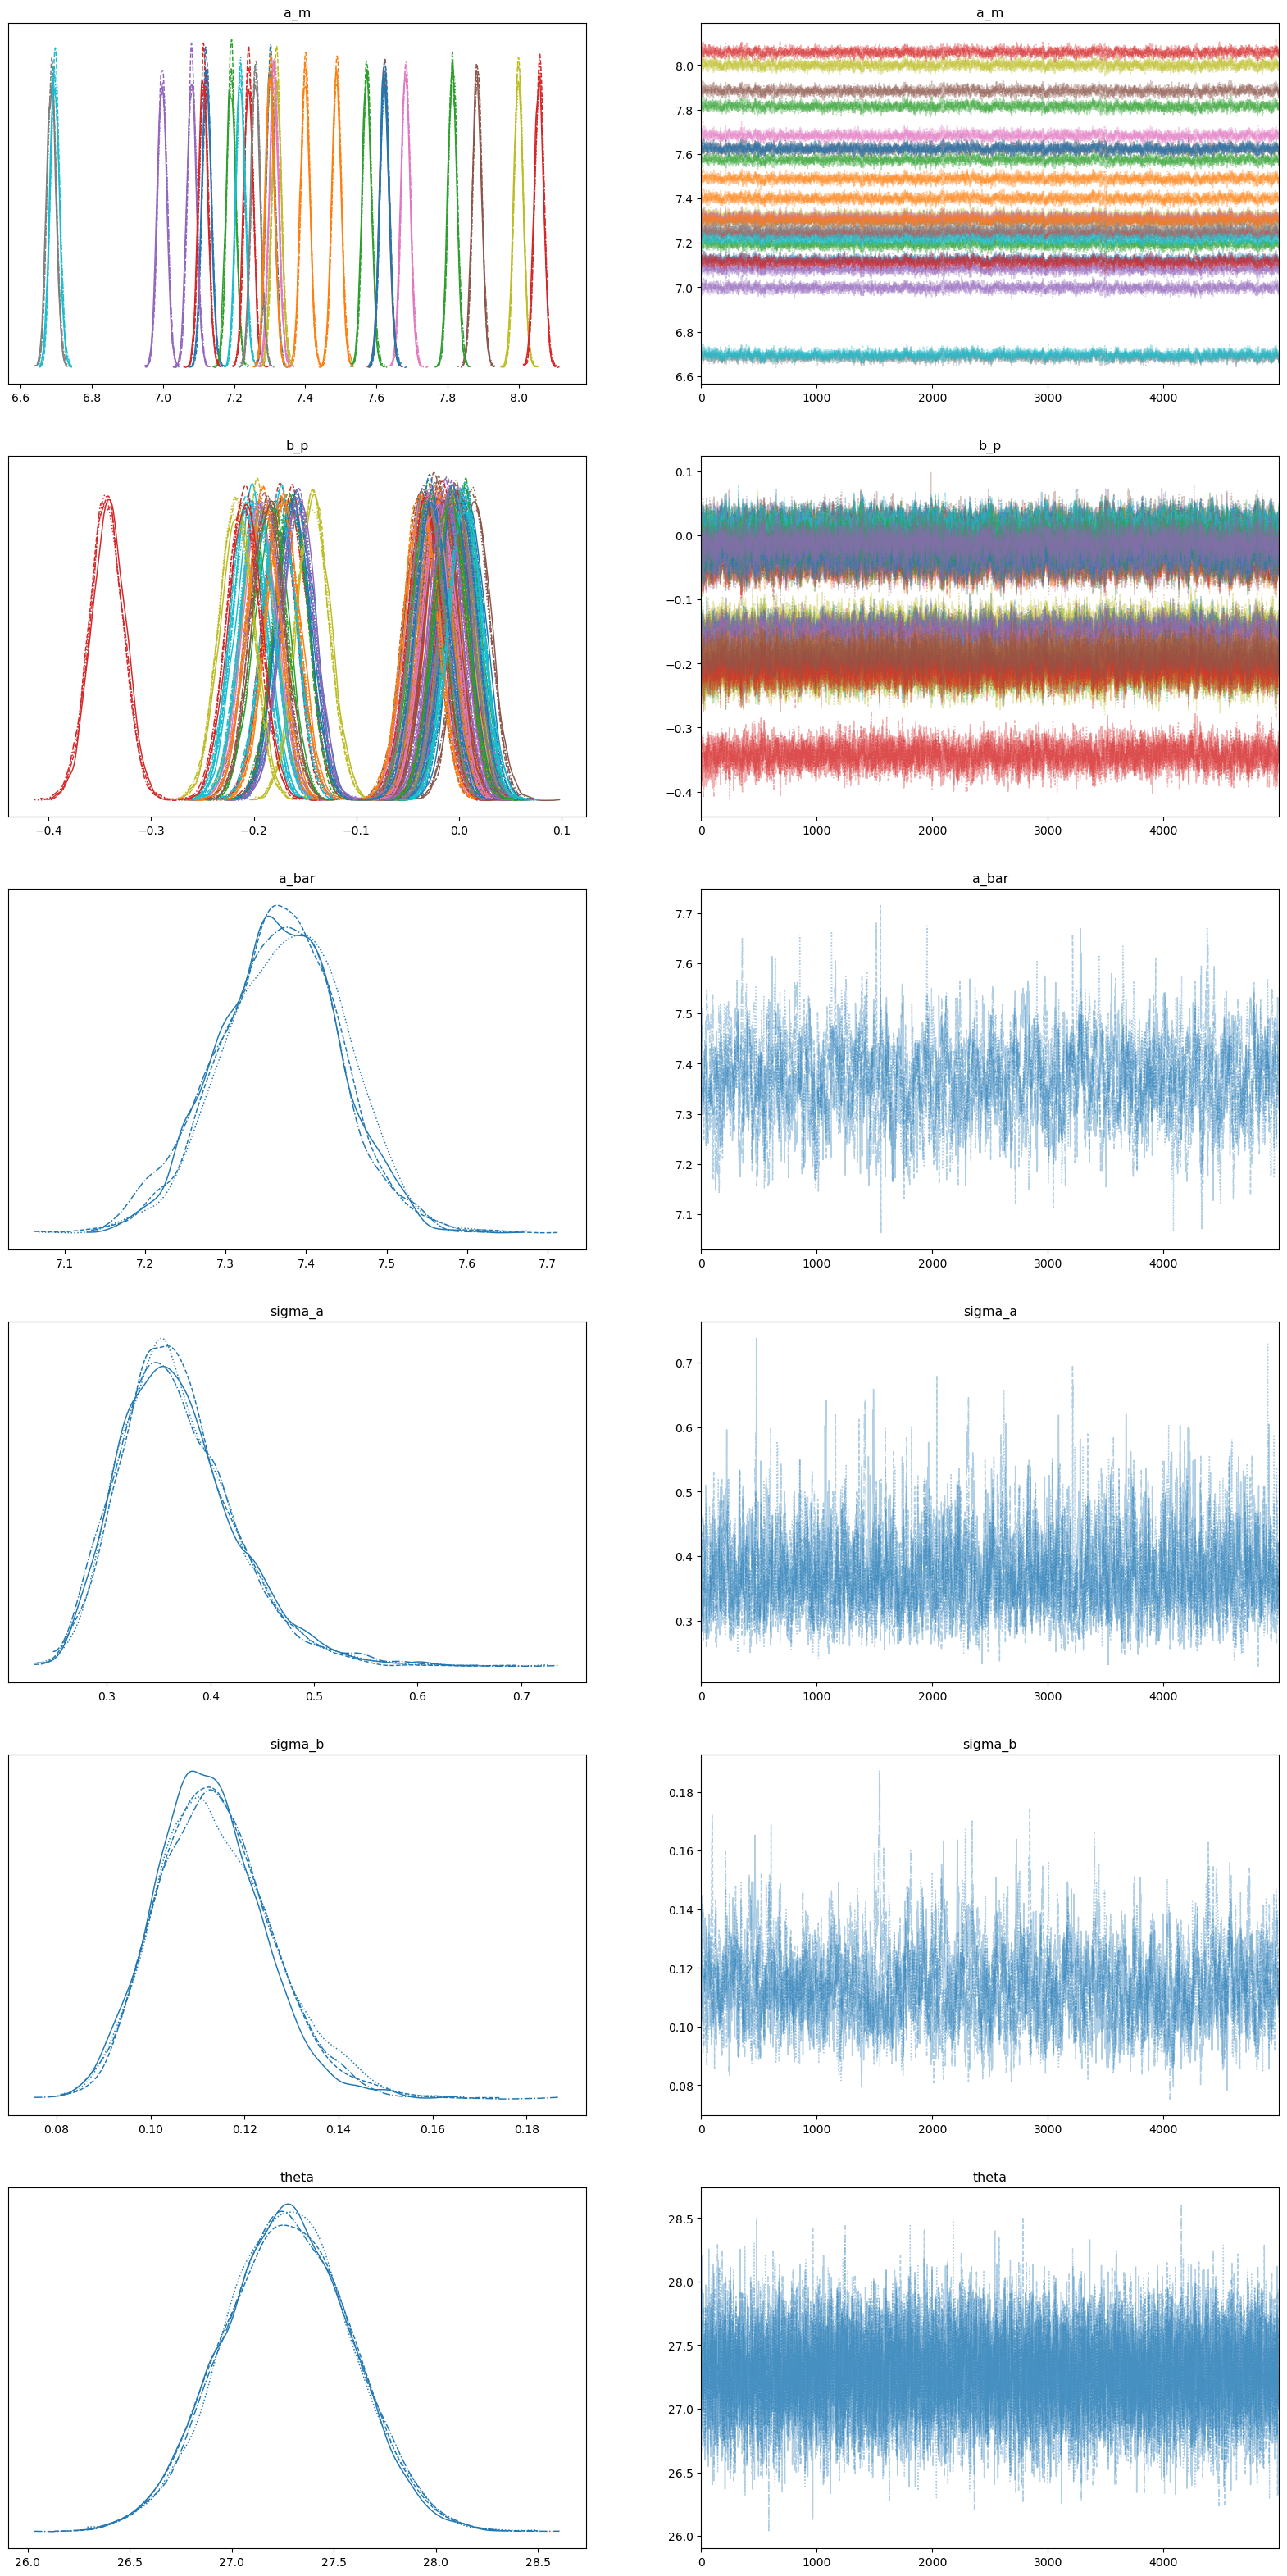

In [3]:
az.plot_trace(idata, var_names=variable_list, figsize=(20, 40))

### Transformed effects

In [4]:
import arviz as az
import pandas as pd
from utils.inference_data_helper import create_inference_data_from_trace, log_to_exp
pd.set_option('display.max_rows', 500)  # Increase number of rows

# Example usage
trace = az.from_netcdf("../multi_parameter/overhead_model_multi_parameter.nc")
variable_list = ['a_m', 'b_p', 'a_bar', 'sigma_a', 'sigma_b', 'theta' ]
transformations = {
    'a_m': log_to_exp,
    'b_p': log_to_exp,
    'g_mp': log_to_exp,
    'a_bar': log_to_exp,
}

idata_transformed = create_inference_data_from_trace(trace, variable_list, transformations)
summary_transformed = az.summary(idata_transformed, variable_list, hdi_prob=0.89)


In [5]:
from utils.summary_table_formatting import update_table, get_replacement_list
from utils.design_matrix_creator import get_design_matricies

_, module_matrix, parameter_matrix, interaction_matrix = get_design_matricies(pd.read_csv("../multi_parameter/combined_data/statistics.csv"), 'AlgorithmIterations')

module_names = get_replacement_list(module_matrix.columns)
parameter_names = get_replacement_list(parameter_matrix.columns)
interaction_names = get_replacement_list(interaction_matrix.columns)

update_table(summary_transformed, 'a_m', replacement=module_names)
update_table(summary_transformed, 'b_p', replacement=parameter_names)
update_table(summary_transformed, 'g_mp', replacement=interaction_names)

summary_transformed.sort_values(by='mean', ascending=True)

Module Matrix shape: (16080, 24)
Parameter Matrix shape: (16080, 66)
Interaction Matrix shape: (16080, 1584)
Observation Matrix shape: (16080, 1)


mean       sd  hdi_5.5%  \
sigma_b                                     0.114    0.012     0.094   
sigma_a                                     0.369    0.056     0.283   
b_p[Pop|TestInsertionProb]                  0.710    0.012     0.691   
b_p[TestChangeProb|TestInsertionProb]       0.805    0.013     0.784   
b_p[TestInsertProb|TestInsertionProb]       0.811    0.013     0.789   
b_p[ChangeParamProb|TestInsertionProb]      0.814    0.013     0.793   
b_p[ChromLen|TestInsertionProb]             0.816    0.014     0.794   
b_p[RandPert|TestInsertionProb]             0.821    0.014     0.799   
b_p[Crossover|TestInsertionProb]            0.822    0.014     0.801   
b_p[Elite|TestInsertionProb]                0.823    0.014     0.801   
b_p[TestDeleteProb|TestInsertionProb]       0.826    0.014     0.804   
b_p[StatemInsertProb|TestInsertionProb]     0.826    0.014     0.805   
b_p[TestInsertionProb|TourSize]             0.830    0.014     0.808   
b_p[Pop|TestInsertProb]                     0.832    0.014     0.811   
b_p[Pop|StatemInsertProb]                   0.839    0.014     0.817   
b_p[ChromLen|Pop]                           0.840    0.014     0.818   
b_p[Pop|TestDeleteProb]                     0.842    0.014     0.821   
b_p[ChangeParamProb|Pop]                    0.849    0.014     0.827   
b_p[Crossover|Pop]                          0.849    0.014     0.827   
b_p[Elite|Pop]                              0.851    0.014     0.828   
b_p[Pop|TourSize]                           0.854    0.014     0.833   
b_p[Pop|TestChangeProb]                     0.854    0.014     0.831   
b_p[Pop|RandPert]                           0.867    0.014     0.844   
b_p[Crossover|TestChangeProb]               0.963    0.016     0.938   
b_p[StatemInsertProb|TestChangeProb]        0.963    0.016     0.938   
b_p[Crossover|TestDeleteProb]               0.966    0.016     0.941   
b_p[RandPert|TestDeleteProb]                0.968    0.016     0.944   
b_p[StatemInsertProb|TestInsertProb]        0.968    0.016     0.943   
b_p[TestChangeProb|TestInsertProb]          0.969    0.016     0.944   
b_p[StatemInsertProb|TestDeleteProb]        0.970    0.016     0.945   
b_p[Elite|StatemInsertProb]                 0.972    0.016     0.947   
b_p[TestChangeProb|TestDeleteProb]          0.973    0.016     0.949   
b_p[TestDeleteProb|TestInsertProb]          0.974    0.016     0.948   
b_p[Crossover|TestInsertProb]               0.976    0.016     0.951   
b_p[ChromLen|TestDeleteProb]                0.977    0.016     0.951   
b_p[Elite|RandPert]                         0.979    0.016     0.954   
b_p[ChromLen|StatemInsertProb]              0.979    0.016     0.953   
b_p[ChangeParamProb|TestChangeProb]         0.979    0.016     0.953   
b_p[RandPert|TestChangeProb]                0.980    0.016     0.956   
b_p[Elite|TestInsertProb]                   0.981    0.016     0.956   
b_p[Crossover|RandPert]                     0.983    0.016     0.958   
b_p[ChromLen|Crossover]                     0.983    0.016     0.958   
b_p[Crossover|Elite]                        0.983    0.016     0.957   
b_p[RandPert|StatemInsertProb]              0.984    0.016     0.958   
b_p[TestInsertProb|TourSize]                0.987    0.016     0.962   
b_p[ChangeParamProb|TestDeleteProb]         0.990    0.016     0.965   
b_p[ChromLen|TestChangeProb]                0.990    0.016     0.962   
b_p[ChangeParamProb|Crossover]              0.991    0.016     0.965   
b_p[TestDeleteProb|TourSize]                0.991    0.016     0.966   
b_p[StatemInsertProb|TourSize]              0.991    0.016     0.965   
b_p[RandPert|TestInsertProb]                0.992    0.016     0.965   
b_p[Crossover|StatemInsertProb]             0.992    0.016     0.966   
b_p[RandPert|TourSize]                      0.993    0.016     0.967   
b_p[ChromLen|TestInsertProb]                0.995    0.016     0.969   
b_p[Elite|TestChangeProb]                   0.995    0.016     0.968   
b_p[Elite|Tes

array([[<Axes: title={'center': 'a_m'}>, <Axes: title={'center': 'a_m'}>],
       [<Axes: title={'center': 'b_p'}>, <Axes: title={'center': 'b_p'}>],
       [<Axes: title={'center': 'a_bar'}>,
        <Axes: title={'center': 'a_bar'}>],
       [<Axes: title={'center': 'sigma_a'}>,
        <Axes: title={'center': 'sigma_a'}>],
       [<Axes: title={'center': 'sigma_b'}>,
        <Axes: title={'center': 'sigma_b'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

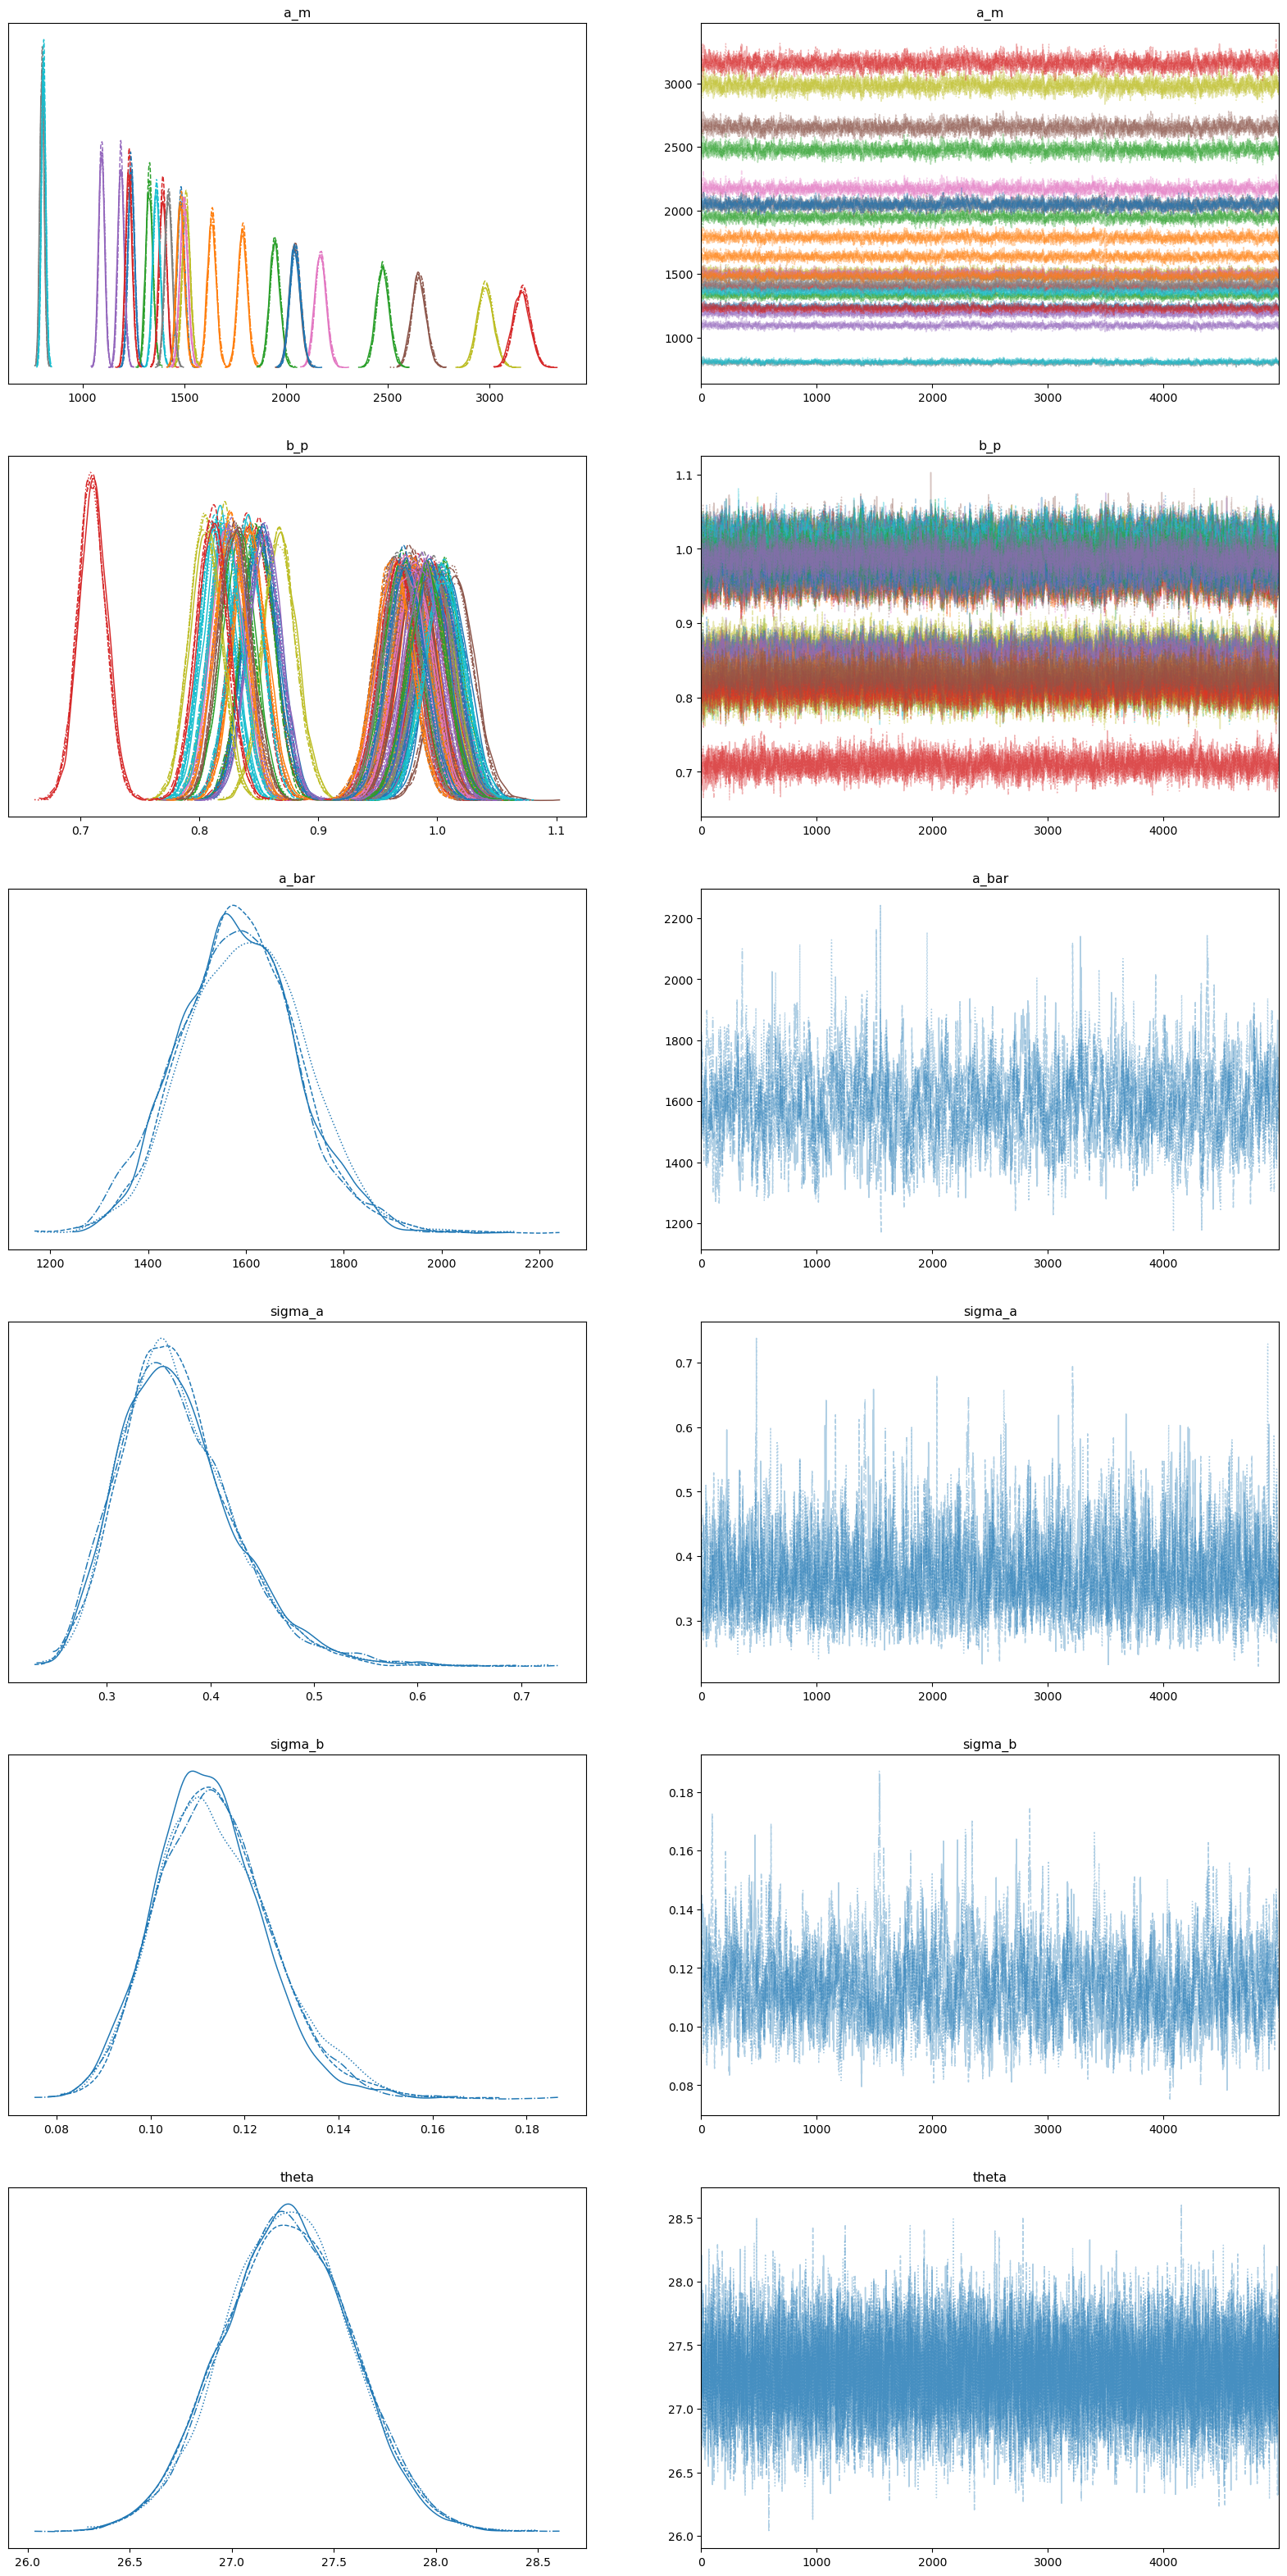

In [6]:
az.plot_trace(idata_transformed, var_names=variable_list, figsize=(20, 40))